### Import all the required libraries

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from pycaret import classification
import time
pd.set_option('display.max_columns', 500)

In [36]:
## Defined few methods to aggregate the data of an employee for last 3 months. By making Number 3 as a parameter this functions can be used 
def last_3_mean(x):
    return x[-3:].mean()

def last_3_std(x):
    return x[-3:].std()

def last_3_min(x):
    return x[-3:].min()

def last_3_max(x):
    return x[-3:].max()

In [12]:
## This Method Filters the Emploees based on the MIN_RECORDS_REQUIRED threshold and also creates the Target_variable 'Has_Left'
def pre_process(df):
    
    ## Get the count of each employeee along with attritioned or not
    df_counts = df.groupby('Emp_ID').count().reset_index()[['Emp_ID','MMM-YY','LastWorkingDate']]
    df_counts.columns = ['Emp_ID','Rec_Avail','Has_Left']
    
    ## Discard the employees who doesn't have data for less than "MIN_RECORDS_REQUIRED" Months using the above counts obtained
    df_selected_emp = df_counts[df_counts['Rec_Avail']>=MIN_RECORDS_REQUIRED][['Emp_ID','Has_Left']]

    ## get the completed data of above selected employees which will be used for Trainning
    df_filtered_train = df[df['Emp_ID'].isin(df_selected_emp['Emp_ID'].values)]
    df_filtered_train = df_filtered_train.set_index('Emp_ID').join(df_counts.set_index('Emp_ID'))
    
    ## get the completed data of all the employees who are present in the given Test Data
    df_filtered_val = df[df['Emp_ID'].isin(test_df['Emp_ID'].values)]
    df_filtered_val = df_filtered_val.set_index('Emp_ID').join(df_counts.set_index('Emp_ID'))
    
    return df_selected_emp,df_filtered_train,df_filtered_val

In [75]:
##The below method aggregates the monthly data and last 3 months data of Employees on various levels Like Average, Median, Maximum, Minimum  and combines them into 1 dataFrame

def process_data(df):
    temp_df1 = df.groupby('Emp_ID').last()[redundant_cols]
    last_df = df.groupby('Emp_ID').last().drop(columns=redundant_cols)
    first_df = df.groupby('Emp_ID').first().drop(columns=redundant_cols)
    mean_df = df.groupby('Emp_ID').mean().drop(columns=nr_cols)
    std_df = df.groupby('Emp_ID').std().drop(columns=nr_cols)
    median_df = df.groupby('Emp_ID').median().drop(columns=nr_cols)
    diff_df = (((last_df-first_df)/last_df)*100)[diff_cols]
    min_df = df.groupby('Emp_ID').min().drop(columns=nr_cols+redundant_cols)
    max_df = df.groupby('Emp_ID').max().drop(columns=nr_cols+redundant_cols)
    total_months = (temp_df1['MMM-YY'].dt.to_period('M').astype(int)  -temp_df1['Dateofjoining'].dt.to_period('M').astype(int) )
    last3_avg_df = df.groupby('Emp_ID').agg(last_3_mean).drop(columns=nr_cols+dates_cols)
    last3_std_df = df.groupby('Emp_ID').agg(last_3_std).drop(columns=nr_cols+dates_cols)
    last3_min_df = df.groupby('Emp_ID').agg(last_3_min).drop(columns=nr_cols+dates_cols+redundant_cols)
    last3_max_df = df.groupby('Emp_ID').agg(last_3_max).drop(columns=nr_cols+dates_cols+redundant_cols)
    merged_df = (temp_df1
               .join(first_df,rsuffix='_first')
               .join(diff_df,rsuffix='_diff')
               .join(mean_df,rsuffix='_mean')
               .join(std_df,rsuffix='_std')
               .join(median_df,rsuffix='_median')
               .join(last3_avg_df,rsuffix='_last3_mean')
               .join(last3_std_df,rsuffix='_last3_std')
               .join(last3_min_df,rsuffix='_last3_min')
               .join(last3_max_df,rsuffix='_last3_max')
              )
    merged_df['Total_Months'] = total_months
    return merged_df

## Some more addition feature engineering is done on the above obtained merged DataFrame
def additional_proccesing(df):
    df['promotion_level'] = df['Designation'] - df['Joining Designation']
    df['Education_Level'] = df['Education_Level'].map({'College':1,'Bachelor':2,'Master':3})
    df['Total_Business_Value_By_Age'] = df['Total Business Value'] / df['Age']
    df['Total_Business_Value_By_Salary'] = df['Total Business Value'] / df['Salary']
    df['Designation_with_rating'] = df['Designation'] / df['Quarterly Rating']
    df['Age_with_salary'] = df['Salary'] / df['Age']
    df['Education_X_Designation'] = df['Education_Level'] * df['Designation']
    return df

## The below method produces the Final DataFrame that is required for Trainning and Test Dataset that can be used with the model
def process_train_test(df_selected_emp,df_filtered,train=True): 
    create = True
    
    if train:
        for idx in df_selected_emp['Emp_ID'].values:
            temp_df = df_filtered.loc[idx][:-TOTAL_LAG].reset_index()
            temp_df = process_data(temp_df)

            if create:
                df = pd.DataFrame(index=df_selected_emp['Emp_ID'].values , columns=temp_df.columns.tolist())
                create = False

            df.loc[idx] = temp_df.values
        
        df = additional_proccesing(df)
        df['Rec_used'] = df['Rec_Avail'] - TOTAL_LAG
        return df
    
    else:
        temp_df = df_filtered.reset_index()
        df = process_data(temp_df)
        df = additional_proccesing(df)
        df['Rec_used'] = df['Rec_Avail']
        return df

In [81]:
## The below method is used to train the model which is implemented using the Pycaret library and the model with the best F1 Score is selected as Final Model
def train_model(df,train_size,ignore_cols):
    
    setup = classification.setup(data=df,
                                 target='Has_Left',
                                 train_size=train_size,
                                 ignore_features=ignore_cols,
                                 session_id=42,
                                 silent=True)
    
    best_model = classification.compare_models(sort='F1')
    train_preds = classification.predict_model(model,verbose=1)
    return best_model,train_preds

## The Model is then evaluated with the given Test Data and the obtained predictions are stored in a csv File
def model_predictions(model,df):
    preds = classification.predict_model(model,data=df.drop(columns=['Has_Left']))

    out_file = f'preds/preds_gbc_{int(time.time())}.csv'
    test_df.set_index('Emp_ID').join(preds[['Label']]).rename(columns={'Label':'Target'}).to_csv(out_file)
    print (f'saved to {out_file}')

In [78]:
## The below 2 methods are used to obtained the important featuresRanked by descending order
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def var_imp_plot(imp_df):
    plt.figure(figsize=(15,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')
    plt.show()


In [79]:

## Read given Train and Test Data
test_df = pd.read_csv('data\\test_hXY9mYw.csv')
train_df = pd.read_csv('data\\train_MpHjUjU.csv')

## Initial Preprocessing of the data
dates_cols = ['MMM-YY','Dateofjoining','LastWorkingDate']
train_df[dates_cols] = train_df[dates_cols].astype('datetime64')

## Lists with columns names that will be used for pre-processing
redundant_cols = ['MMM-YY','Age','Gender','City','Education_Level','Dateofjoining','LastWorkingDate','Rec_Avail','Has_Left','Joining Designation']
diff_cols = ['Salary','Designation']
nr_cols = ['Age','Rec_Avail','Has_Left','Joining Designation']
ignore_cols = ['MMM-YY','Dateofjoining','Rec_Avail','LastWorkingDate']


train_size = 0.7  ## Trainning size to be used
MIN_RECORDS_REQUIRED = 4 ## It is used to select only those employees records who has monthly historical data that is equal to or greater than the said value.
TOTAL_LAG = 3  ##It is used so that the last n months of the employee historical data will be not considered for Trainning 

def __main__():
    ## Pre-process the Train data to filter and obtain few important dataframes
    df_selected_emp,df_filtered_train,df_filtered_val = pre_process(train_df)

    ## Process the Train and Test Data to obtain dataframes that will be directly used for trainning and Testing
    df_train = process_train_test(df_selected_emp,df_filtered_train,train=True)
    df_val   = process_train_test(df_selected_emp,df_filtered_val,train=False)

    ## Train the model using the Pycaret Library
    model,_ = train_model(df_train,train_size,ignore_cols)

    ## Obtain predictions for our Test Dataset
    model_predictions(model,df_val)

    ## Get the important features according to the model and plt those importances
    importances = model.feature_importances_
    column_names = classification.get_config('X_train').columns
    importance_df = imp_df(column_names,importances)

    var_imp_plot(importance_df.head(20))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8385,0.9008,0.9346,0.8420,0.8855,0.6138,0.6252,1.7290
gbc,Gradient Boosting Classifier,0.8327,0.8929,0.9358,0.8349,0.8820,0.5973,0.6110,0.0560
xgboost,Extreme Gradient Boosting,0.8269,0.8849,0.9025,0.8491,0.8742,0.5968,0.6029,0.1420
rf,Random Forest Classifier,0.8236,0.8724,0.9148,0.8368,0.8739,0.5826,0.5900,0.1020
lightgbm,Light Gradient Boosting Machine,0.8186,0.8849,0.8951,0.8438,0.8681,0.5782,0.5832,0.0590
ada,Ada Boost Classifier,0.8129,0.8795,0.9160,0.8244,0.8675,0.5521,0.5626,0.0220
ridge,Ridge Classifier,0.8080,0.0000,0.9099,0.8226,0.8636,0.5419,0.5517,0.0050
lda,Linear Discriminant Analysis,0.8080,0.8404,0.9062,0.8247,0.8631,0.5437,0.5524,0.0080
et,Extra Trees Classifier,0.7947,0.8383,0.8741,0.8283,0.8502,0.5245,0.5276,0.0960
dt,Decision Tree Classifier,0.7783,0.7500,0.8346,0.8343,0.8338,0.5002,0.5019,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8330,0.8939,0.9402,0.8333,0.8835,0.5924,0.6060


saved to preds/preds_gbc_1637604054.csv


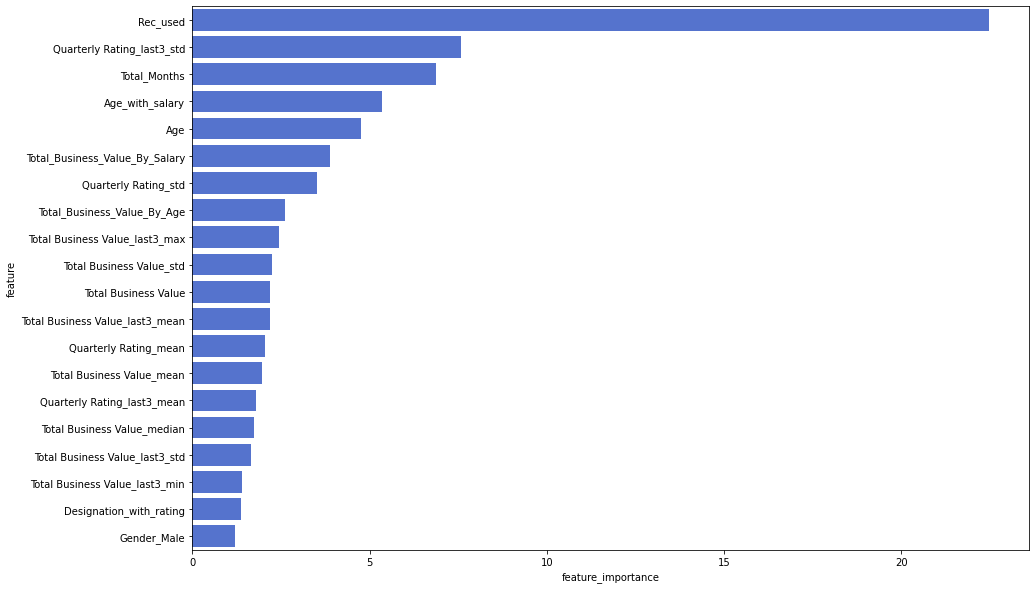

In [82]:
__main__()